# Diffusion pseudotime on mouse embryonic fibroblasts

## Library imports

In [1]:
import os
import sys

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")
scv.settings.plot_prefix = ""

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "realtime_kernel" / "mef", exist_ok=True)

## Data loading

In [5]:
adata = cr.datasets.reprogramming_schiebinger(DATA_DIR / "mef" / "reprogramming_schiebinger.h5ad")
adata = adata[adata.obs["serum"] == "True"].copy()

adata.obs["day"] = adata.obs["day"].astype(float)
adata.uns["cell_sets_colors"] = sns.color_palette("colorblind").as_hex()[: len(adata.obs["cell_sets"].cat.categories)]

adata

DEBUG: Loading dataset from `'/vol/storage/philipp/code/cellrank2_reproducibility/data/mef/reprogramming_schiebinger.h5ad'`


AnnData object with n_obs × n_vars = 165892 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

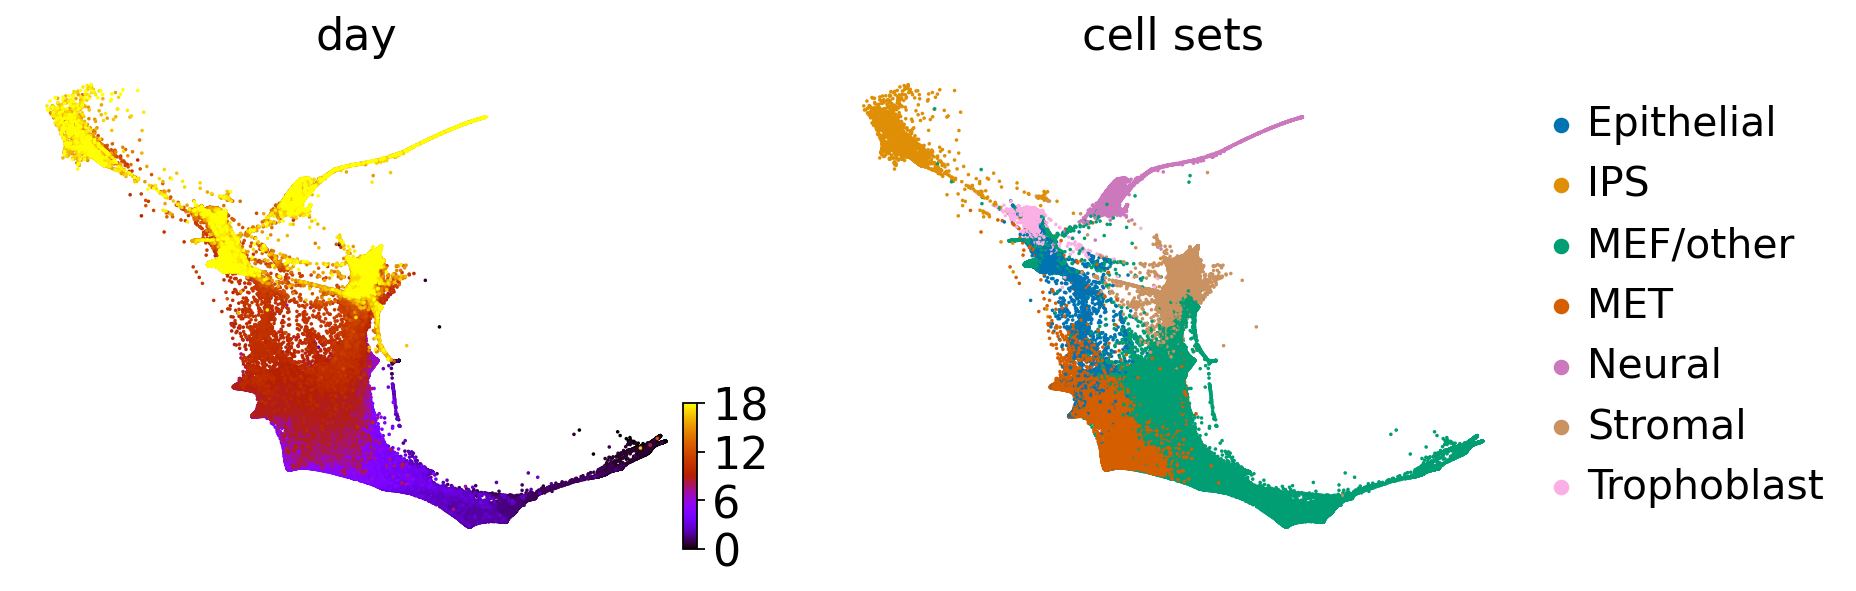

In [6]:
scv.pl.scatter(adata, basis="force_directed", c=["day", "cell_sets"], legend_loc="right", cmap="gnuplot")

## Data pre-processing

In [7]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:24)


In [8]:
sc.pp.neighbors(adata, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:02:53)


## Compute transition matrix

## Pseudotime construction

In [9]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99842936 0.99783903 0.9975883  0.9963944  0.9959189
     0.9931838  0.99124026 0.9910287  0.9904962  0.986064   0.9836965
     0.9807428  0.9771579  0.9766188 ]
    finished (0:00:06)


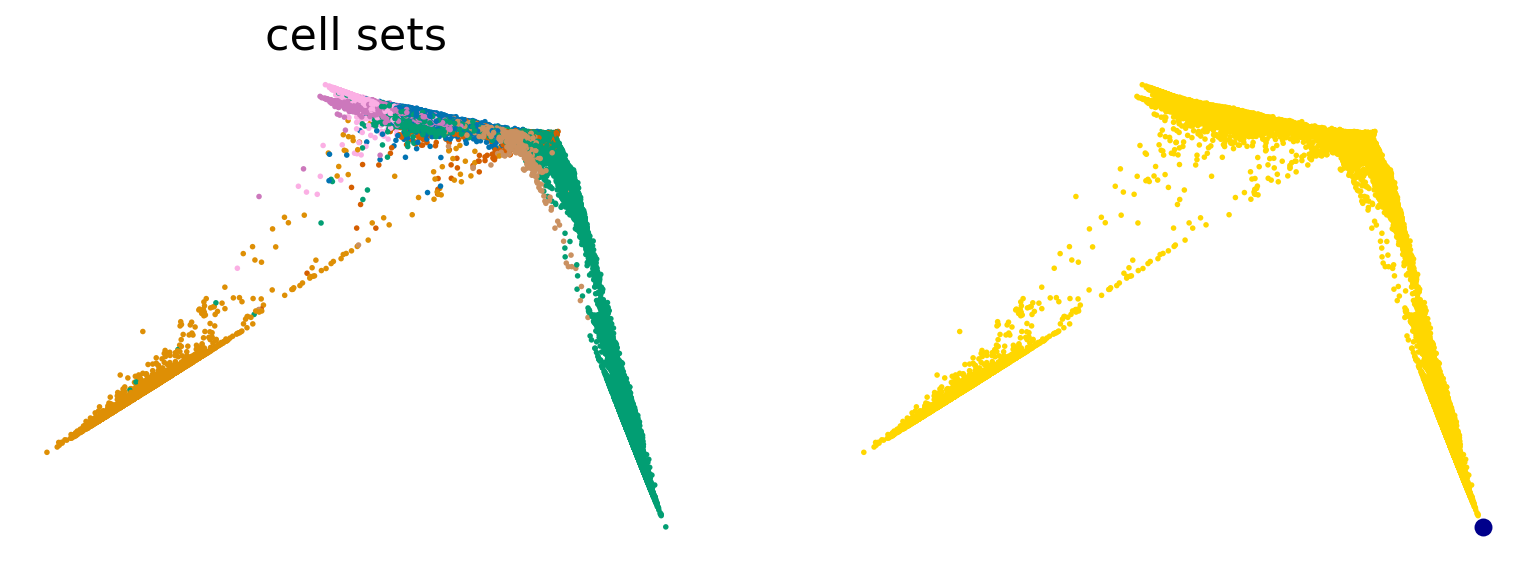

In [10]:
root_idx = 433  # adata.obsm['X_diffmap'][:, 1].argmax()
scv.pl.scatter(adata, basis="diffmap", color=["cell_sets", root_idx], components=["1, 2"], size=25)

In [11]:
adata.uns["iroot"] = root_idx  # np.flatnonzero(adata.obs['day'] == '0.0')[0]
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


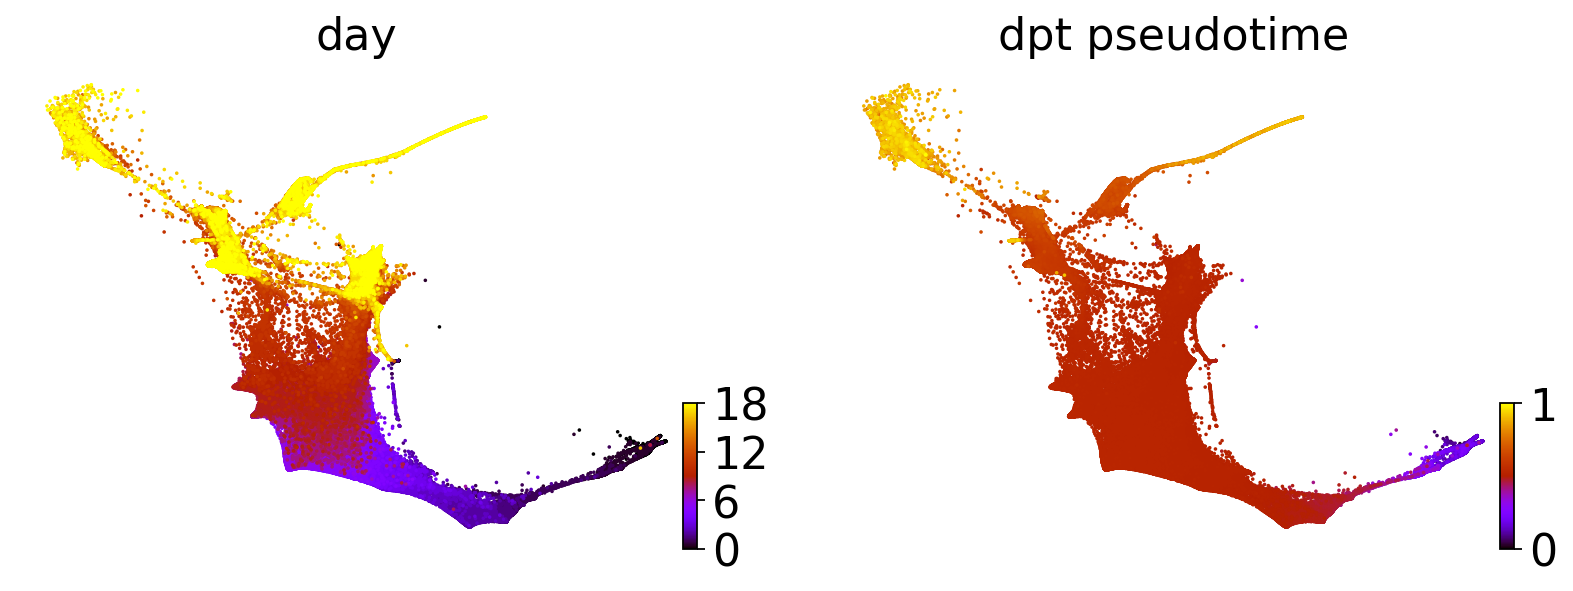

In [12]:
scv.pl.scatter(adata, basis="force_directed", c=["day", "dpt_pseudotime"], legend_loc="none", cmap="gnuplot")

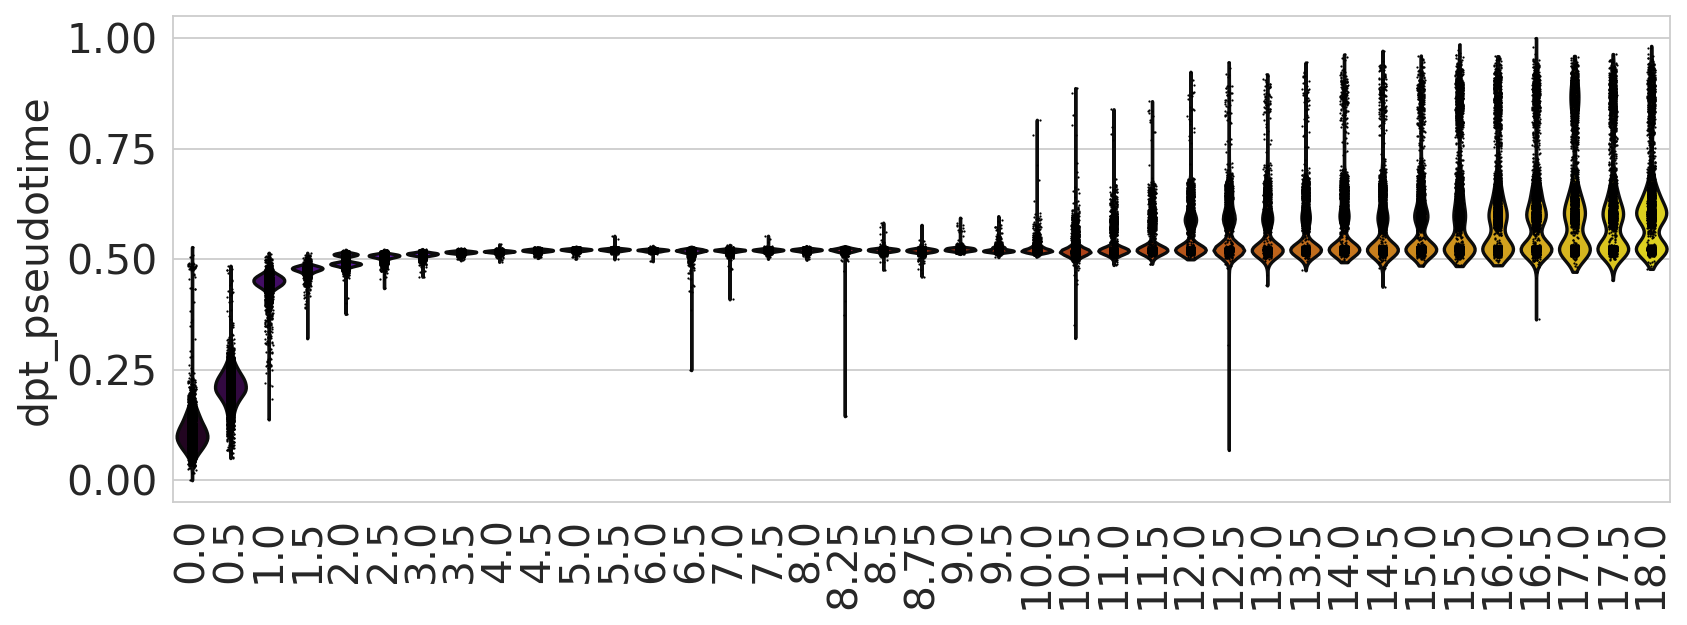

In [13]:
adata.obs["day"] = adata.obs["day"].astype("category")

sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 4))
sc.pl.violin(adata, keys=["dpt_pseudotime"], groupby="day", rotation=90, ax=ax)

if SAVE_FIGURES:
    ax.hlines([0, 0.25, 0.5, 0.75, 1], xmin=-0.75, xmax=39, linestyles="solid", colors="black", zorder=0)
    ax.axis("off")
    fig.savefig(
        FIG_DIR / "realtime_kernel" / "mef" / "dpt_vs_time_point.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )
sns.reset_orig()

In [14]:
spearmanr(adata.obs["dpt_pseudotime"].values, adata.obs["day"].astype(float).values)

SpearmanrResult(correlation=0.7780849690857964, pvalue=0.0)